In [221]:
%matplotlib inline
import os
import random
import json
import cPickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

In [274]:
def get_image_from_json_path(path):
    return os.path.join("../images/scaled", os.path.splitext(os.path.basename(path))[0] + ".jpg")

In [359]:
# get_image will return a numpy array of its colors to input the network
def get_file_colors(path):
    with open(path, 'r') as f:
        j = json.load(f)
        colors = []
        for c in j['imgdata'][1]['clusters']['cluster']:
            f = float(c[0]['f'])
            r, g, b = int(c[1]['rgb'][0]['r']), int(c[1]['rgb'][0]['g']), int(c[1]['rgb'][0]['b'])
            hx = c[2]['hex'][0]['hex']
            h, s, v = int(c[3]['hsv'][0]['h']), int(c[3]['hsv'][0]['s']), int(c[3]['hsv'][0]['v'])
            colors.append([f, hx, r, g, b, h, s, v])
    return colors

In [194]:
files_path = '../output-colors'
max_num_files = 10000

files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(files_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.json']]
if max_num_files < len(files):
    files = [files[i] for i in sorted(random.sample(xrange(len(files)), max_num_files))]

print("keeping %d files to analyze" % len(files))

keeping 2275 files to analyze


In [360]:
paths_colors = []
for file_path in tqdm(files):
    feat = get_file_colors(file_path);
    paths_colors.append([file_path,feat])

100%|██████████| 2275/2275 [00:16<00:00, 137.55it/s]


In [361]:
paths_colors[0]

['../output-colors/d20ab1073d937e47fae528a74f894827.json',
 [[0.274412, u'#47422D', 71, 66, 45, 48, 36, 28],
  [0.264632, u'#CEA87C', 206, 168, 124, 32, 40, 81],
  [0.217279, u'#887553', 136, 117, 83, 39, 39, 53],
  [0.183603, u'#B6653F', 182, 101, 63, 19, 65, 71],
  [0.060074, u'#E2DACD', 226, 218, 205, 38, 10, 89]]]

In [375]:
# gets all color values (minus hex) and builds a new weighted list for all images
def organize_features(paths_colors):
    files = zip(*paths_colors)[0]
    color_data = zip(*paths_colors)[1]
    features = []
    # apply scores to a file
    for index, f in tqdm(enumerate(files)):
        rgbhsv_list = []
        rgbhsv_all = zip(*color_data[index])[2:]
        c1, c2, c3, c4, c5 = zip(*rgbhsv_all)
        [rgbhsv_list.extend(c) for c in [c1, c2, c3, c4, c5]]
        features.append(rgbhsv_list)
    return files, features

In [376]:
files, features = organize_features(paths_colors)

2275it [00:00, 56167.32it/s]


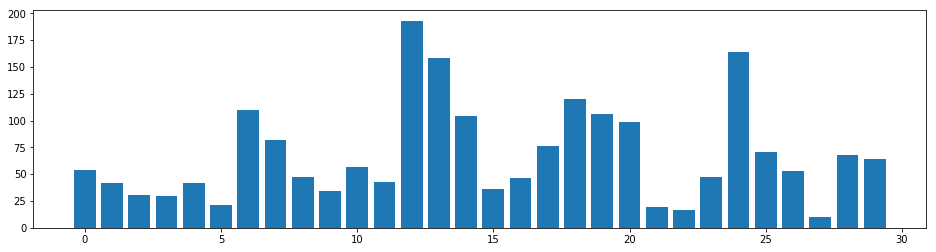

In [392]:
random_item = features[int(len(features) * random.random())]
matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.bar(range(len(random_item)), random_item)
matplotlib.pyplot.show()

In [395]:
feature_values = np.array([x for x in features])
pca = PCA(n_components=30)
pca.fit(feature_values)
pca_features = pca.transform(feature_values)

In [275]:
def get_closest_images(query_image_idx, pca_features, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        filename = get_image_from_json_path(images[idx])
        img = image.load_img(filename)
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5,1,'result images')

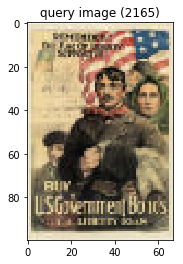

In [396]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx, pca_features)
query_image = get_concatenated_images([query_image_idx], 100)
results_image = get_concatenated_images(idx_closest, 80)

# display the query image
matplotlib.pyplot.figure(figsize = (6,4))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,4))
imshow(results_image)
matplotlib.pyplot.title("result images")

In [399]:
matplotlib.pyplot.imsave("../output-ml4a/colors-v1-nearest-source.png", query_image)
matplotlib.pyplot.imsave("../output-ml4a/colors-v1-nearest.png", results_image)

In [400]:
pickle.dump([images, pca_features], open('../output-ml4a/colors-v1-features.p', 'wb'))

In [402]:
feature_values2 = np.array([x for x in features])
pca2 = PCA(n_components=3)
pca2.fit(feature_values2)
pca_features2 = pca2.transform(feature_values2)

Text(0.5,1,'result images')

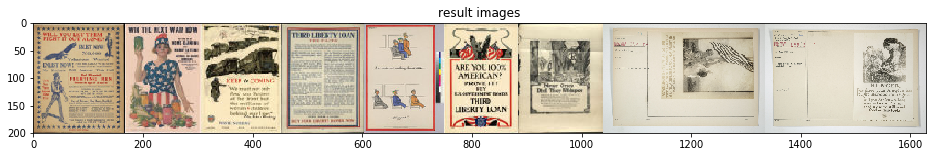

In [408]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, pca_features, num_hops=4):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features[query_image_idx_1] + (1.0-t) * pca_features[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

# pick image and number of hops
num_hops = 8
query_image_idx_1 = int(len(images) * random.random())
query_image_idx_2 = int(len(images) * random.random())

# get path
path = get_image_path_between(query_image_idx_1, query_image_idx_2, pca_features2, num_hops)

# draw image
path_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(path_image)
matplotlib.pyplot.title("result images")

In [409]:
matplotlib.pyplot.imsave("../output-ml4a/colors-v1-path.png", path_image)

In [272]:
from sklearn.manifold import TSNE
from PIL import Image

In [410]:
images, pca_features = pickle.load(open('../output-ml4a/colors-v1-features.p', 'r'))

for i, f in zip(images, pca_features)[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

image: ../output-colors/d20ab1073d937e47fae528a74f894827.json, features: 44.77,-182.24,9.82,150.20... 
image: ../output-colors/660a78367fa1828680c0fa6b9d836ad3.json, features: 226.85,-90.99,15.37,107.06... 
image: ../output-colors/46128d7ba8b4fae362edcd19e3b8b352.json, features: 12.07,6.35,39.22,154.74... 
image: ../output-colors/dec47f8fdc59580ec19a5276e8213fe3.json, features: -0.33,36.60,-191.09,115.17... 
image: ../output-colors/a65c8bffe508caf3264bfc7367888cb5.json, features: 26.45,-46.05,-41.48,-185.42... 


In [411]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2275 samples in 0.095s...
[t-SNE] Computed neighbors for 2275 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2275
[t-SNE] Computed conditional probabilities for sample 2000 / 2275
[t-SNE] Computed conditional probabilities for sample 2275 / 2275
[t-SNE] Mean sigma: 51.421172
[t-SNE] Computed conditional probabilities in 0.204s
[t-SNE] Iteration 50: error = 80.0709152, gradient norm = 0.0036391 (50 iterations in 8.135s)
[t-SNE] Iteration 100: error = 76.2350464, gradient norm = 0.0100131 (50 iterations in 5.606s)
[t-SNE] Iteration 150: error = 75.8853989, gradient norm = 0.0007974 (50 iterations in 6.316s)
[t-SNE] Iteration 200: error = 75.8801117, gradient norm = 0.0000519 (50 iterations in 4.866s)
[t-SNE] Iteration 250: error = 75.8799896, gradient norm = 0.0000252 (50 iterations in 5.319s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.879990
[t-SNE] Iteration 300: err

In [412]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

100%|██████████| 2275/2275 [00:16<00:00, 139.39it/s]


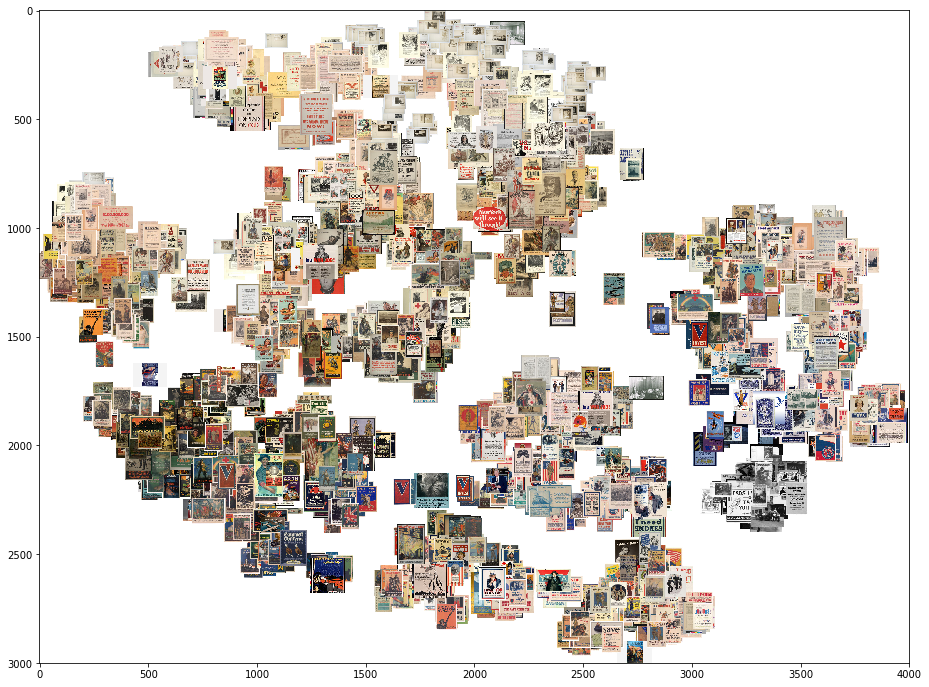

In [413]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(get_image_from_json_path(img))
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [414]:
full_image.save("../output-ml4a/colors-v1-tSNE.png")

In [415]:
tsne_path = "../output-ml4a/colors-v1-tSNE-points.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ../output-ml4a/colors-v1-tSNE-points.json


In [416]:
import rasterfairy

# nx * ny ≈ the number of images
nx = 53
ny = 43

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

In [417]:
tile_width = 60
tile_height = 80

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(get_image_from_json_path(img))
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

100%|██████████| 2275/2275 [00:13<00:00, 164.91it/s]


In [418]:
matplotlib.pyplot.figure(figsize = (20,20))
imshow(grid_image)

In [419]:
grid_image.save("../output-ml4a/colors-v1-tSNE-grid.jpg")